In [1]:
try:
    from tensorflow import __version__ as tf_version

    TF = True
except ImportError:
    TF = False

if TF:
    from tensorflow import keras
    from keras import backend as K
else:
    import keras
    from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

import pbt
from pbt.utils import train_population

Using TensorFlow backend.


In [2]:
sns.set_style('white')

In [3]:
if TF:
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
else:
    sess = K.get_session()
K.set_session(sess)

In [4]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 16  # one step in a member is equivalent to train on a batch
TOTAL_STEPS = 1000  # total number of steps before ending training
STEPS_READY = 100  # number of steps before updating a member
STEPS_SAVE = STEPS_READY  # number of steps before saving the status of the population

In [5]:
# ------------------------------------------
# SEARCH SPACE
# ------------------------------------------
l1_values = np.geomspace(1e-10, 0.1, num=3).tolist()
lr_values = np.geomspace(1e-3, 1e-2, num=4).tolist()
dropout_rate_values = np.geomspace(1e-10, 1e-1, num=3).tolist()
param_grid = ParameterGrid(dict(lr=lr_values, l1=l1_values, dropout_rate=dropout_rate_values))

In [6]:
def build_fn(data_dim, lr=0.001, l1=0, l2=0, dropout_rate=0):
    """Returns a function which can be called with no parameters to create a new
     model.

    The returned function is required by Member, which invokes it to construct a
    new instance of the model.

    Returns:
        function: a function that can be called to get a compiled Keras model.

    """

    def _build_fn():
        # Set seed to get same weight initialization
        np.random.seed(42)
        model = keras.models.Sequential([
            keras.layers.Dense(64,
                               activation='relu',
                               input_shape=(data_dim,),
                               kernel_regularizer=pbt.hyperparameters.l1_l2(l1, l2)),
            pbt.hyperparameters.DropoutMutable(rate=dropout_rate),
            keras.layers.Dense(1,
                               kernel_regularizer=pbt.hyperparameters.l1_l2(l1, l2))
        ])
        adam = keras.optimizers.Adam(lr=lr)
        model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
        return model

    return _build_fn

In [7]:
def show_results(df):
    print('***** RESULTS *****')
    population_size = df['model_id'].nunique()
    df_final = df.tail(population_size)
    print('** Ranking **')
    print(df_final[['model_id', 'loss']].sort_values('loss'))
    print('** Statistics **')
    print(df_final['loss'].describe())
    print('** Best hyperparameters **')
    best = df.iloc[[df_final['loss'].idxmin()]]
    print(best.filter(regex="(.+:.+)|lr"))

In [8]:
# Load dataset. Split training dataset into train and validation sets
dataset = keras.datasets.boston_housing
(x_train, y_train), (x_test, y_test) = dataset.load_data()
print('Train examples: {}, test examples: {}'.format(
    x_train.shape[0], x_test.shape[0]
))
data_dim = x_train.shape[1]

Train examples: 404, test examples: 102


In [9]:
# ------------------------------------------
# GRID SEARCH
# ------------------------------------------

K.clear_session()
population = []
print('** EXPERIMENT WITH GRID SEARCH OF {} **'.format(len(param_grid)))
# We create a population where we never explore new hyperparameters
for h in param_grid:
    member = pbt.members.Member(build_fn(data_dim, **h),
                                tune_lr=True, steps_ready=None)
    population.append(member)

res_gs = train_population(population, x_train, y_train, BATCH_SIZE,
                          TOTAL_STEPS, STEPS_SAVE, VALIDATION_SPLIT)
show_results(res_gs)

** EXPERIMENT WITH GRID SEARCH OF 36 **
1000/1000 [==============================] - 198s 198ms/step - min: 20.3614 - max: 44.1267 - mean: 34.5546
***** RESULTS *****
** Ranking **
            model_id       loss
354  140595591339704  20.361427
355  140595589624776  23.486069
351  140595595221032  24.341866
340  140595611909704  27.940723
328  140595962417504  28.097923
334  140595619437704  28.162018
346  140595601659328  28.607584
335  140595618572664  30.478624
353  140595592672760  31.937353
349  140595597773848  31.952663
336  140595617183840  32.095428
324  140596012983072  32.121841
350  140595596583264  32.462135
325  140596012986040  33.650162
337  140595615807304  33.660843
359  140595582273408  34.025681
329  140595961012632  34.075798
341  140595608626008  34.113598
347  140595600313984  35.407024
358  140595583617120  35.618229
352  140595593875296  36.513618
348  140595599131536  36.527912
333  140595956362656  36.693829
345  140595603382112  36.803879
331  14059736368109

In [10]:
# ------------------------------------------
# PBT
# ------------------------------------------
population_sizes = [6, 12, 18, 24, 30, 36]
res_pbt = {}

for pop_size in reversed(population_sizes):
    K.clear_session()
    population = []
    print('** EXPERIMENT WITH POP SIZE {} **'.format(pop_size))
    # Create Population
    for i in np.linspace(0, len(param_grid) - 1, pop_size):
        h_idx = int(round(i))
        h = param_grid[h_idx]
        member = pbt.members.Member(build_fn(data_dim, **h),
                                    tune_lr=True, steps_ready=STEPS_READY)
        population.append(member)
    # Train!
    res = train_population(population, x_train, y_train, BATCH_SIZE,
                           TOTAL_STEPS, STEPS_SAVE, VALIDATION_SPLIT)
    print('Best loss:')
    print(res.iloc[[res.tail(pop_size)['loss'].idxmin()]])
    res_pbt[pop_size] = res

** EXPERIMENT WITH POP SIZE 36 **
1000/1000 [==============================] - 317s 317ms/step - min: 17.8146 - max: 23.9818 - mean: 20.6006
Best loss:
          loss         model_id  step  loss_smoothed      l1:0  l2:0  \
359  17.814596  140595967735232  1000      20.345514  0.000002   0.0   

         dr:1      l1:2  l2:2        lr  
359  0.159252  0.000005   0.0  0.010617  
** EXPERIMENT WITH POP SIZE 30 **
1000/1000 [==============================] - 237s 237ms/step - min: 19.6217 - max: 25.3205 - mean: 20.2476
Best loss:
          loss         model_id  step  loss_smoothed      l1:0  l2:0  \
291  19.621731  140595578922488  1000      22.384488  0.000004   0.0   

         dr:1      l1:2  l2:2        lr  
291  0.191103  0.000003   0.0  0.008493  
** EXPERIMENT WITH POP SIZE 24 **
1000/1000 [==============================] - 167s 167ms/step - min: 18.4116 - max: 24.9827 - mean: 21.9117
Best loss:
          loss         model_id  step  loss_smoothed          l1:0  l2:0  \
227  18.41

In [11]:
baseline_loss = res_gs[res_gs['step'] == TOTAL_STEPS]['loss'].min()
pbt_losses = [res_pbt[s].tail(s)['loss'].min() for s in population_sizes] 

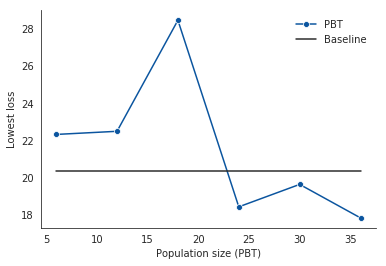

In [12]:
sns.lineplot(x=population_sizes, y=pbt_losses, style=0, markers=True,
             color='#0b559f', legend=False, label='PBT')
plt.plot([population_sizes[0], population_sizes[-1]], [baseline_loss]*2,
         color='#2b2b2b', label='Baseline')
plt.xlabel('Population size (PBT)')
plt.ylabel('Lowest loss')
plt.legend(frameon=False)
sns.despine()
plt.show()

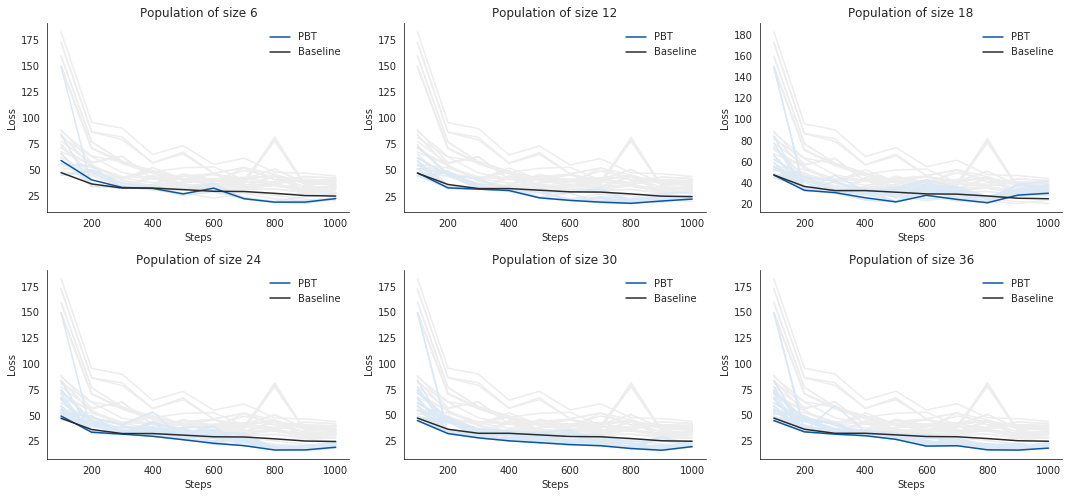

In [16]:
AVERAGE_TOP = 5
plt.figure(figsize=(15, 10))

cols = 3
rows = int(np.floor(len(population_sizes) / cols)) + 1

df_gs = res_gs
df_gs_top = df_gs.sort_values(['step','loss']) \
                  .groupby('step').head(AVERAGE_TOP) \
                  .groupby('step').mean().reset_index()

for idx, s in enumerate(population_sizes):
    # This are the results from the experiment with population size 's'
    df_pbt = res_pbt[s]
    # Top members (by loss) in the last step
    df_pbt_top = df_pbt.sort_values(['step', 'loss']) \
                       .groupby('step').head(AVERAGE_TOP) \
                       .groupby('step').mean().reset_index()
    ax = plt.subplot(rows, cols, idx + 1)
    sns.lineplot(x='step', y='loss',
                 data=df_gs, estimator=None, units='model_id', color='#ededed', ax=ax)
    sns.lineplot(x='step', y='loss',
                 data=df_pbt, estimator=None, units='model_id', color='#dbe9f6', ax=ax)
    sns.lineplot(x='step', y='loss', data=df_pbt_top, 
                 color='#0b559f', label='PBT', ax=ax)
    sns.lineplot(x='step', y='loss', data=df_gs_top, 
                 color='#2b2b2b', label='Baseline', ax=ax)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    plt.title('Population of size {}'.format(s))
    plt.legend(frameon=False)

sns.despine()
plt.tight_layout()

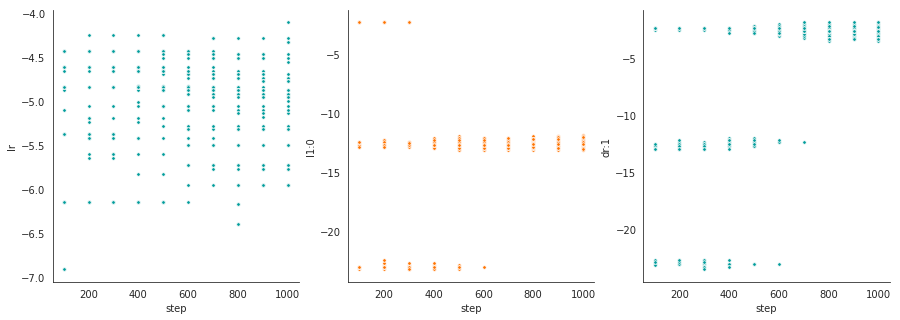

In [14]:
pop_size = 36
df_pbt = res_pbt[pop_size]

f = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
sns.scatterplot(x=df_pbt['step'], y=np.log(df_pbt['lr']), 
                marker='.', s=50, color='#009C9B', ax=ax)
ax = plt.subplot(132)
sns.scatterplot(x=df_pbt['step'], y=np.log(df_pbt['l1:0']), 
                marker='.', s=50, color='#FF7300', ax=ax)
ax = plt.subplot(133)
sns.scatterplot(x=df_pbt['step'], y=np.log(df_pbt['dr:1']), 
                marker='.', s=50, color='#009C9B', ax=ax)
sns.despine()

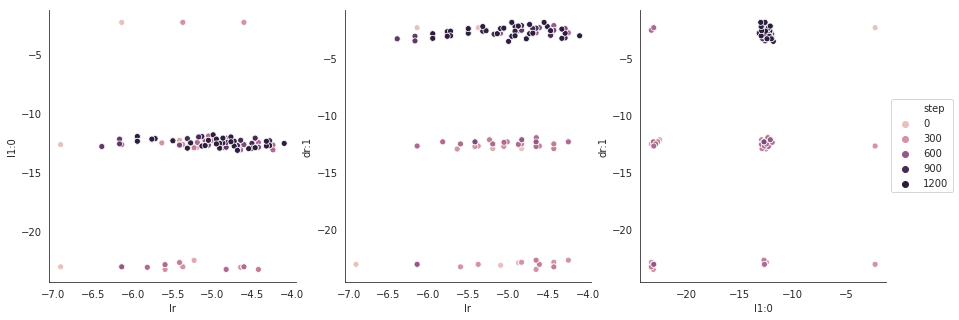

In [15]:
pop_size = 36
df_pbt = res_pbt[pop_size]

pal=sns.cubehelix_palette(light=0.8, as_cmap=True)

f = plt.figure(figsize=(15, 5))
ax = plt.subplot(131)
sns.scatterplot(x=np.log(df_pbt['lr']), 
                y=np.log(df_pbt['l1:0']), 
                hue=df_pbt['step'], palette=pal, ax=ax)
ax.legend().remove()
ax = plt.subplot(132)
sns.scatterplot(x=np.log(df_pbt['lr']), 
                y=np.log(df_pbt['dr:1']), 
                hue=df_pbt['step'], palette=pal, ax=ax)
ax.legend().remove()
ax = plt.subplot(133)
sns.scatterplot(x=np.log(df_pbt['l1:0']), 
                y=np.log(df_pbt['dr:1']), 
                hue=df_pbt['step'], palette=pal, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()